v1.0 2024-04-26
1. 把命令行参数修改为适配jupiter模式，增加一个函数，既可以从命令行获取参数，也可以从jupiter中获取参数
2. 把整个程序按照jupiter分段，方便调试

### 导入库

In [1]:
import pandas as pd
import numpy as np
import os
import argparse # v1.0 用来解析命令行参数
import sys
import time
import logging
from logging.handlers import RotatingFileHandler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### 超参设置

In [2]:
frame = "pytorch"  # 可选： "keras", "pytorch", "tensorflow"
if frame == "pytorch":
    from model.model_pytorch import train, predict
elif frame == "keras":
    from model.model_keras import train, predict
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'
elif frame == "tensorflow":
    from model.model_tensorflow import train, predict
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'    # tf和keras下会有很多tf的warning，但不影响训练
else:
    raise Exception("Wrong frame seletion")

class Config:
    # 数据参数
    feature_columns = list(range(2, 9))     # 要作为feature的列，按原数据从0开始计算，也可以用list 如 [2,4,6,8] 设置
    label_columns = [4, 5]                  # 要预测的列，按原数据从0开始计算, 如同时预测第四，五列 最低价和最高价
    # label_in_feature_index = [feature_columns.index(i) for i in label_columns]  # 这样写不行
    label_in_feature_index = (lambda x,y: [x.index(i) for i in y])(feature_columns, label_columns)  # 因为feature不一定从0开始

    predict_day = 1             # 预测未来几天

    # 网络参数
    input_size = len(feature_columns)
    output_size = len(label_columns)

    hidden_size = 128           # LSTM的隐藏层大小，也是输出大小
    lstm_layers = 2             # LSTM的堆叠层数
    dropout_rate = 0.2          # dropout概率，示在每次更新时，每个神经元有20%的概率被关闭。防止过度依赖于某个神经元，变成过拟合。
    time_step = 30              # 这个参数很重要，是设置用前多少天的数据来预测，也是LSTM的time step数，请保证训练数据量大于它

    # 训练参数
    do_train = True
    do_predict = True
    add_train = False           # 是否载入已有模型参数进行增量训练
    shuffle_train_data = False   # 是否对训练数据做shuffle，股票的日顺序不应该被打乱。
    use_cuda = True            # 是否使用GPU训练

    train_data_rate = 0.95      # 训练数据占总体数据比例，测试数据就是 1-train_data_rate
    valid_data_rate = 0.15      # 验证数据占训练数据比例，验证集在训练过程使用，为了做模型和参数选择。验证数据是在模型训练过程中用来评估模型性能和调整模型参数的数据，它不参与模型的训练。

    batch_size = 64
    learning_rate = 0.001
    epoch = 20                  # 整个训练集被训练多少遍，不考虑早停的前提下
    patience = 5                # 训练多少epoch，验证集没提升就停掉
    random_seed = 2024            # 随机种子，保证可复现

    do_continue_train = False    # 每次训练把上一次的final_state作为下一次的init_state，仅用于RNN类型模型，目前仅支持pytorch
    continue_flag = ""           # 但实际效果不佳，可能原因：仅能以 batch_size = 1 训练
    if do_continue_train:
        shuffle_train_data = False
        batch_size = 1
        continue_flag = "continue_"

    # 训练模式
    debug_mode = False  # 调试模式下，是为了跑通代码，追求快
    debug_num = 500  # 仅用debug_num条数据来调试

    # 框架参数
    used_frame = frame  # 选择的深度学习框架，不同的框架模型保存后缀不一样
    model_postfix = {"pytorch": ".pth", "keras": ".h5", "tensorflow": ".ckpt"}
    model_name = "model_" + continue_flag + used_frame + model_postfix[used_frame]

    # 路径参数
    train_data_path = "./data/stock_data.csv"
    model_save_path = "./checkpoint/" + used_frame + "/"
    figure_save_path = "./figure/"
    log_save_path = "./log/"
    do_log_print_to_screen = True
    do_log_save_to_file = True                  # 是否将config和训练过程记录到log
    do_figure_save = False
    do_train_visualized = False          # 训练loss可视化，pytorch用visdom，tf用tensorboardX，实际上可以通用, keras没有
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)    # makedirs 递归创建目录
    if not os.path.exists(figure_save_path):
        os.mkdir(figure_save_path)
    if do_train and (do_log_save_to_file or do_train_visualized):
        cur_time = time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())
        log_save_path = log_save_path + cur_time + '_' + used_frame + "/"
        os.makedirs(log_save_path)

### 训练与测试数据

In [5]:
class Data:
    def __init__(self, config):
        self.config = config
        self.data, self.data_column_name = self.read_data()

        self.data_num = self.data.shape[0]
        self.train_num = int(self.data_num * self.config.train_data_rate)

        self.mean = np.mean(self.data, axis=0)              # 数据的均值和方差
        self.std = np.std(self.data, axis=0)
        self.norm_data = (self.data - self.mean)/self.std   # 归一化，去量纲

        self.start_num_in_test = 0      # 测试集中前几天的数据会被删掉，因为它不够一个time_step

    def read_data(self):                # 读取初始数据
        if self.config.debug_mode:
            init_data = pd.read_csv(self.config.train_data_path, nrows=self.config.debug_num,
                                    usecols=self.config.feature_columns)
        else:
            init_data = pd.read_csv(self.config.train_data_path, usecols=self.config.feature_columns)
        return init_data.values, init_data.columns.tolist()     # .columns.tolist() 是获取列名

    def get_train_and_valid_data(self):
        feature_data = self.norm_data[:self.train_num]
        label_data = self.norm_data[self.config.predict_day : self.config.predict_day + self.train_num,
                                    self.config.label_in_feature_index]    # 将延后几天的数据作为label

        if not self.config.do_continue_train:
            # 在非连续训练模式下，每time_step行数据会作为一个样本，两个样本错开一行，比如：1-20行，2-21行。。。。
            train_x = [feature_data[i:i+self.config.time_step] for i in range(self.train_num-self.config.time_step)]
            train_y = [label_data[i:i+self.config.time_step] for i in range(self.train_num-self.config.time_step)]
        else:
            # 在连续训练模式下，每time_step行数据会作为一个样本，两个样本错开time_step行，
            # 比如：1-20行，21-40行。。。到数据末尾，然后又是 2-21行，22-41行。。。到数据末尾，……
            # 这样才可以把上一个样本的final_state作为下一个样本的init_state，而且不能shuffle
            # 目前本项目中仅能在pytorch的RNN系列模型中用
            train_x = [feature_data[start_index + i*self.config.time_step : start_index + (i+1)*self.config.time_step]
                       for start_index in range(self.config.time_step)
                       for i in range((self.train_num - start_index) // self.config.time_step)]
            train_y = [label_data[start_index + i*self.config.time_step : start_index + (i+1)*self.config.time_step]
                       for start_index in range(self.config.time_step)
                       for i in range((self.train_num - start_index) // self.config.time_step)]

        train_x, train_y = np.array(train_x), np.array(train_y)

        train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=self.config.valid_data_rate,
                                                              random_state=self.config.random_seed,
                                                              shuffle=self.config.shuffle_train_data)   # 划分训练和验证集，并打乱
        return train_x, valid_x, train_y, valid_y

    def get_test_data(self, return_label_data=False):
        feature_data = self.norm_data[self.train_num:]
        sample_interval = min(feature_data.shape[0], self.config.time_step)     # 防止time_step大于测试集数量
        self.start_num_in_test = feature_data.shape[0] % sample_interval  # 这些天的数据不够一个sample_interval
        time_step_size = feature_data.shape[0] // sample_interval

        # 在测试数据中，每time_step行数据会作为一个样本，两个样本错开time_step行
        # 比如：1-20行，21-40行。。。到数据末尾。
        test_x = [feature_data[self.start_num_in_test+i*sample_interval : self.start_num_in_test+(i+1)*sample_interval]
                   for i in range(time_step_size)]
        if return_label_data:       # 实际应用中的测试集是没有label数据的
            label_data = self.norm_data[self.train_num + self.start_num_in_test:, self.config.label_in_feature_index]
            return np.array(test_x), label_data
        return np.array(test_x)

### 记录log

In [6]:
def load_logger(config):
    logger = logging.getLogger()
    logger.setLevel(level=logging.DEBUG)

    # StreamHandler
    if config.do_log_print_to_screen:
        stream_handler = logging.StreamHandler(sys.stdout)
        stream_handler.setLevel(level=logging.INFO)
        formatter = logging.Formatter(datefmt='%Y/%m/%d %H:%M:%S',
                                      fmt='[ %(asctime)s ] %(message)s')
        stream_handler.setFormatter(formatter)
        logger.addHandler(stream_handler)

    # FileHandler
    if config.do_log_save_to_file:
        file_handler = RotatingFileHandler(config.log_save_path + "out.log", maxBytes=1024000, backupCount=5)
        file_handler.setLevel(level=logging.INFO)
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)

        # 把config信息也记录到log 文件中
        config_dict = {}
        for key in dir(config):
            if not key.startswith("_"):
                config_dict[key] = getattr(config, key)
        config_str = str(config_dict)
        config_list = config_str[1:-1].split(", '")
        config_save_str = "\nConfig:\n" + "\n'".join(config_list)
        logger.info(config_save_str)

    return logger

### 计算结果绘图

In [7]:
def draw(config: Config, origin_data: Data, logger, predict_norm_data: np.ndarray):
    label_data = origin_data.data[origin_data.train_num + origin_data.start_num_in_test : ,
                                            config.label_in_feature_index]
    predict_data = predict_norm_data * origin_data.std[config.label_in_feature_index] + \
                   origin_data.mean[config.label_in_feature_index]   # 通过保存的均值和方差还原数据
    assert label_data.shape[0]==predict_data.shape[0], "The element number in origin and predicted data is different"

    label_name = [origin_data.data_column_name[i] for i in config.label_in_feature_index]
    label_column_num = len(config.label_columns)

    # label 和 predict 是错开config.predict_day天的数据的
    # 下面是两种norm后的loss的计算方式，结果是一样的，可以简单手推一下
    # label_norm_data = origin_data.norm_data[origin_data.train_num + origin_data.start_num_in_test:,
    #              config.label_in_feature_index]
    # loss_norm = np.mean((label_norm_data[config.predict_day:] - predict_norm_data[:-config.predict_day]) ** 2, axis=0)
    # logger.info("The mean squared error of stock {} is ".format(label_name) + str(loss_norm))

    loss = np.mean((label_data[config.predict_day:] - predict_data[:-config.predict_day] ) ** 2, axis=0)
    loss_norm = loss/(origin_data.std[config.label_in_feature_index] ** 2)
    logger.info("The mean squared error of stock {} is ".format(label_name) + str(loss_norm))

    label_X = range(origin_data.data_num - origin_data.train_num - origin_data.start_num_in_test)
    predict_X = [ x + config.predict_day for x in label_X]

    if not sys.platform.startswith('linux'):    # 无桌面的Linux下无法输出，如果是有桌面的Linux，如Ubuntu，可去掉这一行
        for i in range(label_column_num):
            plt.figure(i+1)                     # 预测数据绘制
            plt.plot(label_X, label_data[:, i], label='label')
            plt.plot(predict_X, predict_data[:, i], label='predict')
            plt.title("Predict stock {} price with {}".format(label_name[i], config.used_frame))
            logger.info("The predicted stock {} for the next {} day(s) is: ".format(label_name[i], config.predict_day) +
                  str(np.squeeze(predict_data[-config.predict_day:, i])))
            if config.do_figure_save:
                plt.savefig(config.figure_save_path+"{}predict_{}_with_{}.png".format(config.continue_flag, label_name[i], config.used_frame))

        plt.show()

### 运行主函数

[ 2024/04/29 01:41:25 ] 
Config:
'add_train': False
'batch_size': 64
'continue_flag': ''
'cur_time': '2024_04_29_01_40_53'
'debug_mode': False
'debug_num': 500
'do_continue_train': False
'do_figure_save': False
'do_log_print_to_screen': True
'do_log_save_to_file': True
'do_predict': True
'do_train': True
'do_train_visualized': False
'dropout_rate': 0.2
'epoch': 20
'feature_columns': [2, 3, 4, 5, 6, 7, 8]
'figure_save_path': './figure/'
'hidden_size': 128
'input_size': 7
'label_columns': [4, 5]
'label_in_feature_index': [2, 3]
'learning_rate': 0.001
'log_save_path': './log/2024_04_29_01_40_53_pytorch/'
'lstm_layers': 2
'model_name': 'model_pytorch.pth'
'model_postfix': {'pytorch': '.pth'
'keras': '.h5'
'tensorflow': '.ckpt'}
'model_save_path': './checkpoint/pytorch/'
'output_size': 2
'patience': 5
'predict_day': 1
'random_seed': 2024
'shuffle_train_data': False
'time_step': 30
'train_data_path': './data/stock_data.csv'
'train_data_rate': 0.95
'use_cuda': True
'used_frame': 'pytorch'
'va

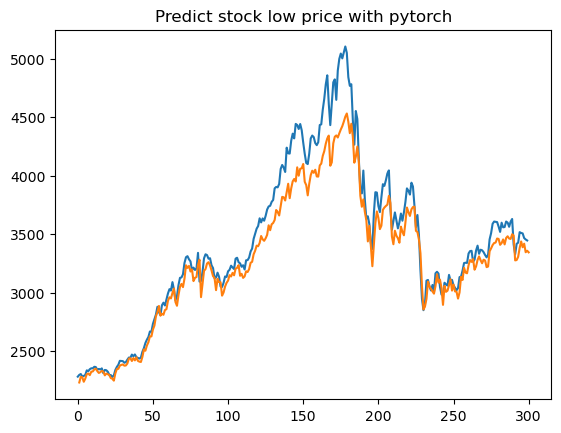

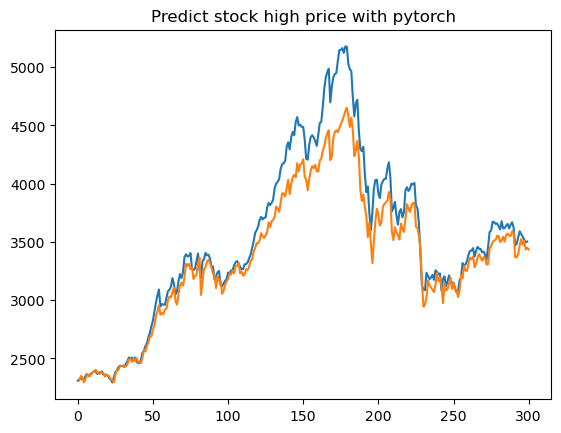

In [8]:
def get_args(): # v1.0 自己写的函数，用来判断是否在notebook环境或者命令行环境，两者获取参数的方式不同。
    parser = argparse.ArgumentParser()
    if any("jupyter" in arg for arg in sys.argv):
        # 如果在Jupyter notebook中运行，手动设置参数
        args = parser.parse_args(args=[])
    else:
        # 如果在命令行中运行，从命令行获取参数
        args = parser.parse_args()
    return args

def main(config):
    logger = load_logger(config)
    try:
        np.random.seed(config.random_seed)  # 设置随机种子，保证可复现
        data_gainer = Data(config)

        if config.do_train:
            train_X, valid_X, train_Y, valid_Y = data_gainer.get_train_and_valid_data()
            train(config, logger, [train_X, train_Y, valid_X, valid_Y])

        if config.do_predict:
            test_X, test_Y = data_gainer.get_test_data(return_label_data=True)
            pred_result = predict(config, test_X)       # 这里输出的是未还原的归一化预测数据
            draw(config, data_gainer, logger, pred_result)
    except Exception:
        logger.error("Run Error", exc_info=True)


if __name__=="__main__":
    import argparse
    # argparse方便于命令行下输入参数，可以根据需要增加更多
    parser = argparse.ArgumentParser()
    # parser.add_argument("-t", "--do_train", default=False, type=bool, help="whether to train")
    # parser.add_argument("-p", "--do_predict", default=True, type=bool, help="whether to train")
    # parser.add_argument("-b", "--batch_size", default=64, type=int, help="batch size")
    # parser.add_argument("-e", "--epoch", default=20, type=int, help="epochs num")
    
    # args = parser.parse_args() v1.0 删除用下面代替
    args = get_args()

    con = Config()
    for key in dir(args):               # dir(args) 函数获得args所有的属性
        if not key.startswith("_"):     # 去掉 args 自带属性，比如__name__等
            setattr(con, key, getattr(args, key))   # 将属性值赋给Config

    main(con)